In [2]:
# read in UCI breast cancer dataset
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
# assign features to array and use LabelEncoder to tarnsform labels into integers

from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

In [5]:
# divide test and training dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [6]:
# chain standardizing scales, compress data from 30 dimeonsions to 2 using PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# chain StandardScaler, PCA, and LogisticRegression
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict( X_test )
test_acc = pipe_lr.score(X_test, y_test)

print(f'Test Accuracy: {test_acc:.3f}')

Test Accuracy: 0.956


In [8]:
# use stratified k-fold cross validation
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d} Class distr.: {np.bincount(y_train[train])} Acc.: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01 Class distr.: [256 153] Acc.: 0.935
Fold: 02 Class distr.: [256 153] Acc.: 0.935
Fold: 03 Class distr.: [256 153] Acc.: 0.957
Fold: 04 Class distr.: [256 153] Acc.: 0.957
Fold: 05 Class distr.: [256 153] Acc.: 0.935
Fold: 06 Class distr.: [257 153] Acc.: 0.956
Fold: 07 Class distr.: [257 153] Acc.: 0.978
Fold: 08 Class distr.: [257 153] Acc.: 0.933
Fold: 09 Class distr.: [257 153] Acc.: 0.956
Fold: 10 Class distr.: [257 153] Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [10]:
# use sklearn k-fold cross validation scorer

from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


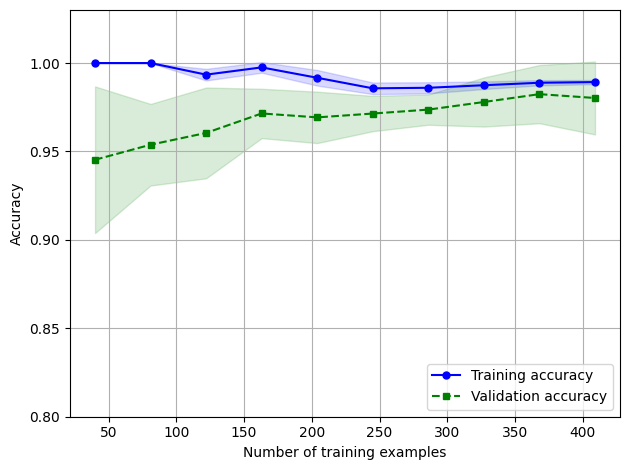

In [11]:
# visualize learning curve

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

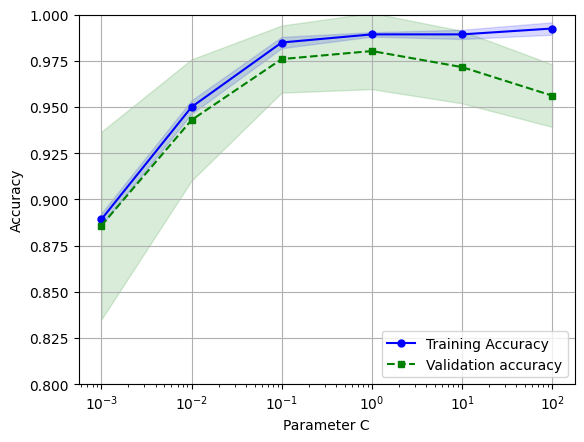

In [12]:
# create validation curve using sklearn

from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve( estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [13]:
# Tune hyperparameters via grid search, exhaustive search that tests list of values for optimal combination

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{ 'svc__C': param_range, 'svc__kernel': ['linear'] },
              { 'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [14]:
# validate best estimator

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


In [16]:
# using randomized search instead of grid search, which instead of taking a list of values 
# can take a distributions to sample from
import scipy

param_range = scipy.stats.loguniform(0.0001, 1000.0)

In [17]:
# draw 10 random samples from distribution via rvs(10) method

np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [18]:
# Use RandomizedSearchCV instead to tune SVM similar to GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid, scoring='accuracy', refit=True, n_iter=20, cv=10, random_state=1, n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)

print(rs.best_params_)

0.9780676328502416
{'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}


In [20]:
# use successive halving which gets rid of poor performing hyperparameter configurations until only one remains
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(pipe_svc, param_distributions=param_grid, n_candidates='exhaust', resource='n_samples', factor=1.5, random_state=1, n_jobs=-1)

In [23]:
# carry out search

hs = hs.fit(X_train, y_train)
print(hs.best_score_)

print(hs.best_params_)

clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

0.9617647058823529
{'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}
Test accuracy: 0.982


In [24]:
# other popular hyperparameter tuning library is hyperopt

# https://github.com/hyperopt/hyperopt
# https://github.com/hyperopt/hyperopt-sklearn

In [25]:
# nested cross-validation with grid search

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


In [26]:
# use nested cross validation to compare SVM model to decision tree

from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


In [28]:
# generate confusion matrix to show true positive, true negative, false positive, false negative

# [[ TP  FN ]
# [  FP  TN ]]

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


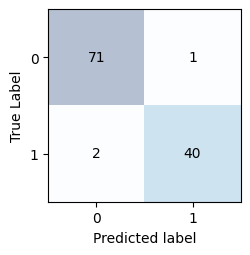

In [29]:
# use matplotlibs matshow function to show confusion matrix

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True Label')
plt.show()

In [30]:
# precision: how many of the records predicted as relevant are actually relevant: TP / (TP + FP)
# recall: how many relevant records are captures as such: TP / (TP + FN)
# harmonic mean of PRE and REC, or F1: 2 * (PRE x REC) / (PRE + REC)
# Matthews Correlated coefficient: harder to interprety but superior metric

# all implemented in sklearn

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')


Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


In [31]:
# specify different positivel mabel using own scorer using f1_score as metric

from sklearn.metrics import make_scorer

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


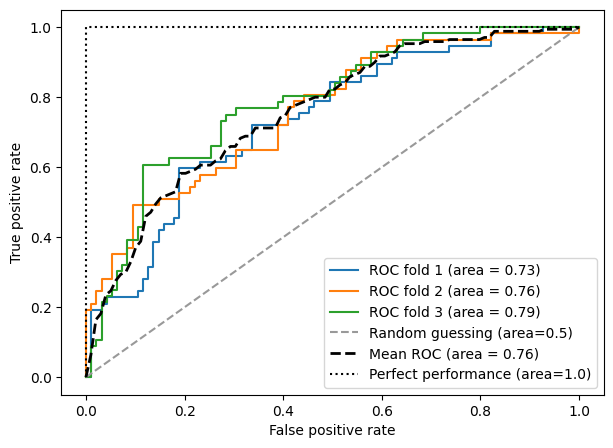

In [32]:
# plotting Reciever operating characteristic (ROC)
# can use to calculate ROC area under the curve (ROC AUC) for characterize performance of classification model

from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)

    mean_tpr += interp(mean_fpr, fpr, tpr)

    mean_tpr[0] = 0.0
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC fold {i + 1} (area = {roc_auc:.2f})')

plt.plot([0,1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label=f'Random guessing (area=0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black', label=f'Perfect performance (area=1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='lower right')

plt.show()

In [33]:
# specify which average metric for the different scoring functions, such as precision score or make scorer

pre_scorer = make_scorer( score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')

In [36]:
# create imbalanced dataset of cancer tumor data for dealing with class imbalance
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[ y == 0], y[y == 1][:40]))

In [37]:
# predict all as benign (class 0) which would still acheive 90% accuracy

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [38]:
# take minority sample (classs 1) and repeatedly draw new samples until it contains the same number of examples as class label 0

from sklearn.utils import resample

print('Number of class 1 examples before:',X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])



Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [39]:
# stack original class examples with upsampled clas 1 subset to obtain balanced dataset

X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))


In [40]:
# majority vote prediction only achieves 50%
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

In [41]:
# Most popular used algorithm for synthetic training data generation is Synthetic Minority Over-sampling Technique (SMOTE)